# Use Case - Churn Prediction

> Data Mining for Business Analytics ADS-505
>
> Fatemeh Khosravi - Stephen Kuc - Ruddy Simonpour

In [144]:
# import dependencies
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pylab as plt
import seaborn as sns

import statsmodels.tools.tools as stattools

from sklearn import preprocessing

# models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


from dmba.metric import AIC_score

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score


In [145]:
os.chdir("/Users/ruddysimonpour/Desktop/ADS505-Applied Data Sci for Business/Project-ADS505/ADS505-Finall-project/Dataset")

In [146]:
bank = pd.read_csv("Bank Customer Churn Prediction.csv",low_memory=False)

In [147]:
# print data
bank.sample(10)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
1603,15593470,576,Germany,Female,36,8,166287.85,1,1,1,23305.85,0
9273,15740160,616,France,Male,31,1,0.00,2,1,1,54706.75,0
3916,15620276,539,Spain,Male,36,6,0.00,3,1,1,118959.64,0
3410,15595937,430,Germany,Male,36,1,138992.48,2,0,0,122373.42,0
2164,15794479,767,Spain,Male,77,8,149083.70,1,1,1,190146.83,0
2603,15583049,643,Germany,Female,34,7,160426.07,1,0,1,188533.11,0
8232,15732704,582,Spain,Male,25,9,148042.97,2,1,0,52341.15,0
9576,15723484,669,Germany,Female,42,1,103873.39,1,1,0,148611.52,0
3594,15578369,652,Germany,Female,37,9,145219.30,1,1,0,159132.83,0
6146,15649112,738,Spain,Female,33,3,122134.40,2,0,1,27867.59,0


In [148]:
# checking the data types
bank.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [149]:
# dataframe shape
print(f'Number of rows in the dataframe {bank.shape[0]}')
print(f'Number of columns in the dataframe {bank.shape[1]}')

Number of rows in the dataframe 10000
Number of columns in the dataframe 12


In [150]:
bank.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
products_number,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
credit_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
churn,10000.0,2.037000e-01,0.402769,0.00,0.00,0.000000e+00,0.000000e+00,1.00


For binary variables, incl target:

Churn: ~20.4% positive records CC: ~70.5% positive active member: ~51.5% positive

For numerical:

cc: seems about symmetrical (median ~= mean); ranges from 350 - 850

age: 18 - 92; slightly skewed right, with mean of 38.9 and median of 37.

tenure: seems symmetrical; anywhere from 0 years to 10 years.

balance: ranges from  0𝑡𝑜 250k. The median > mean (~97k vs 76k), so it is skewed left

estimated salary: mean / median both around 100k. ranges from 57.5k to ~200k.

In [151]:
# checking for missing values
bank.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

There is no missing values in the dataset

In [152]:
# checking for duplicated values
duplicate_values = bank.duplicated().sum()
print(f'The number of duplicated values are : {duplicate_values}')

The number of duplicated values are : 0


In [153]:
# check number of unique values for each column
bank.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

There are only 3 different countries and 4 different products. These two we can make into dummy variables. CC and active member are indeed binary. 

### Visualization

<AxesSubplot:>

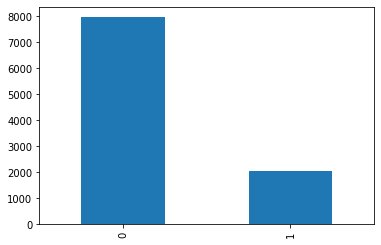

In [154]:
bank["churn"].value_counts().plot(kind="bar")

In [163]:
bank["products_number"].value_counts()

1    5084
2    4590
3     266
4      60
Name: products_number, dtype: int64

In [155]:
# The target variable is not balance

## Data Cleaning

There is not missing values and duplicated values in the dataset. Now we can drop unnecessary columns. "Customer-ID"s are assigned at random and are not based on anything. Therefore, we can remove this column

In [156]:
bank_country = pd.get_dummies(bank['country'], prefix = 'country', drop_first = True)
bank_gender= pd.get_dummies(bank['gender'], prefix = 'gender', drop_first = True)

churn_df = bank.drop(['country', 'gender', 'customer_id'], axis = 1)

churn_df = pd.concat([churn_df, bank_country, bank_gender], axis = 1)

churn_df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [158]:
# change the data type of the dummy variables (uint8 --> int64)
def data_type_change(df,cols):
    df[cols]=df[cols].astype(int)
    return df

churn_df = data_type_change(churn_df,["country_Germany","country_Spain",
                                      "gender_Male"])

churn_df.dtypes

credit_score          int64
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
country_Germany       int64
country_Spain         int64
gender_Male           int64
dtype: object

### Checking outliers

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


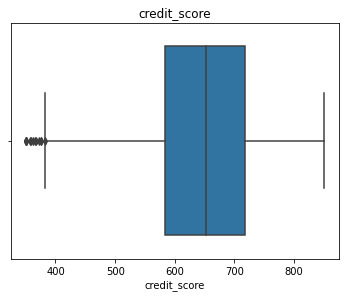

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


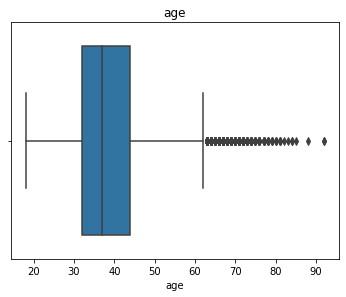

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


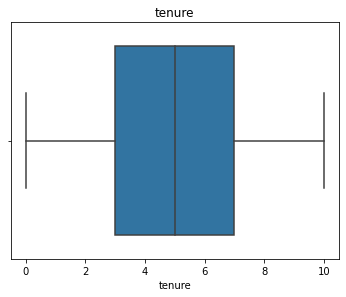

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


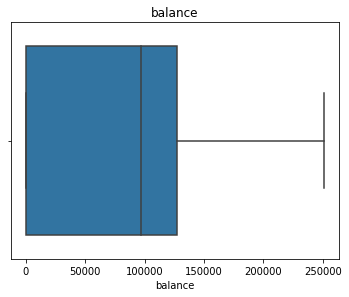

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


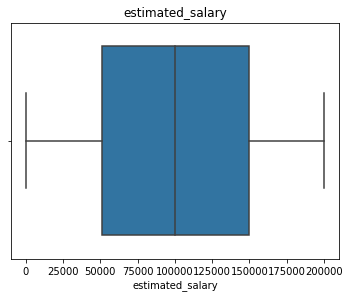

In [159]:
col=bank[['credit_score','age','tenure','balance','estimated_salary']] 
for i in col:
  n=1
  plt.figure(figsize=(20,20))
  plt.subplot(4,3,1)
  sns.boxplot(bank[i])
  plt.title(i)
  plt.show()
  n=n+1

It seems outliers represent their natural variations in the population, no need to remove them from the dataset.

<AxesSubplot:>

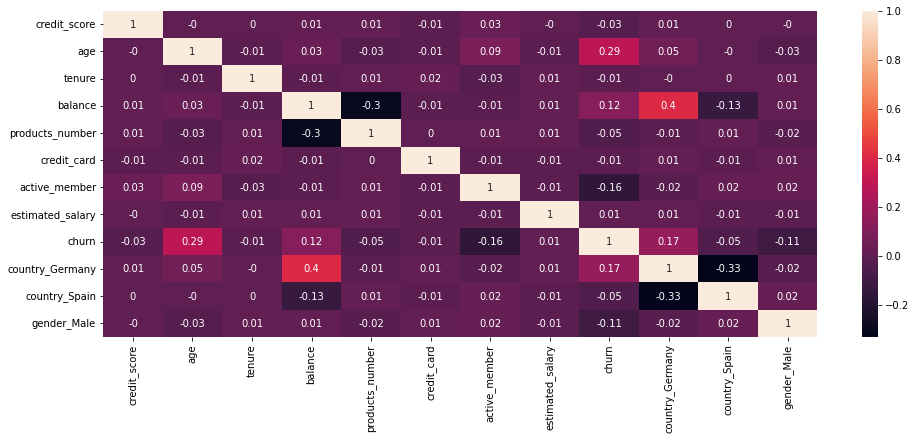

In [160]:
# Correlation matrix
plt.figure(figsize=(16, 6))
sns.heatmap(round(churn_df.corr(),2), annot = True)

highest correlations with churn: age (+.29), product 2 (-.29), product 3 (+.26), country_germany (+.17)

Multi collinearities?

Age -- no, next highest correlation is .09 with active member.

prod_2 -- yes, -.36 with balance; -.15 with prod_3

prod_3 -- not really, except -.15 with prod_2

country_Germany -- .4 with balance; -.33 with country_Spain

In [161]:
# for scaling any numerical 

churn_numerical = churn_df[['credit_score','age', 'tenure','balance', 'estimated_salary']]


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(churn_numerical)

churn_numerical_scaled = scaler.transform(churn_numerical)

churn_numerical_scaled = pd.DataFrame(churn_numerical_scaled, columns = churn_numerical.columns)

churn_numerical_scaled.head()

,credit_score,age,tenure,balance,estimated_salary
0,-0.326221,0.293517,-1.041760,-1.225848,0.021886
1,-0.440036,0.198164,-1.387538,0.117350,0.216534
2,-1.536794,0.293517,1.032908,1.333053,0.240687
3,0.501521,0.007457,-1.387538,-1.225848,-0.108918
4,2.063884,0.388871,-1.041760,0.785728,-0.365276


In [164]:
# We can add these back into the

churn_df_scaled = churn_df.drop(churn_numerical, axis =1)

churn_df_scaled = pd.concat([churn_df_scaled, churn_numerical_scaled], axis = 1)

churn_df_scaled.head(5)

,products_number,credit_card,active_member,churn,country_Germany,country_Spain,gender_Male,credit_score,age,tenure,balance,estimated_salary
0,1,1,1,1,0,0,0,-0.326221,0.293517,-1.041760,-1.225848,0.021886
1,1,0,1,0,0,1,0,-0.440036,0.198164,-1.387538,0.117350,0.216534
2,3,1,0,1,0,0,0,-1.536794,0.293517,1.032908,1.333053,0.240687
3,2,0,0,0,0,0,0,0.501521,0.007457,-1.387538,-1.225848,-0.108918
4,1,1,1,0,0,1,0,2.063884,0.388871,-1.041760,0.785728,-0.365276


## Building Model

#### Imbalance dataset

In [165]:
count_churn = len(churn_df[churn_df['churn']==1])
count_no_churn = len(churn_df[churn_df['churn']==0])

pct_of_no_churn = count_no_churn/(count_no_churn+count_churn)
print("percentage of no churn", pct_of_no_churn*100)

pct_of_churn = count_churn/(count_no_churn+count_churn)
print("percentage of churn", pct_of_churn*100)

percentage of no churn 79.63
percentage of churn 20.369999999999997


In [166]:
class_count0, class_count1 = churn_df.churn.value_counts()


class0_df = churn_df[churn_df["churn"]==0]
class1_df = churn_df[churn_df["churn"]==1]

#### Method1: Under-Sampling

In [167]:
# df_class0_under = class0_df.sample(class_count1)

# df_test_under = pd.concat([df_class0_under, class1_df], axis = 0)

# print(f'Random Under Sampling')
# print(df_test_under.churn.value_counts())

#### Method2: Over-Sampling

In [168]:
# df_class1_under = class1_df.sample(class_count0, replace=True)

# df_test_over = pd.concat([df_class1_under, class0_df],axis=0)
# print(f'Random Over Sampling')
# print(df_test_over.churn.value_counts())

In [169]:
# splitting into X and Y

X = churn_df.drop('churn', axis = 1)
y = churn_df['churn']

#### Method3: SMOTE
!pip install imbalanced-learn

In [170]:
from imblearn.over_sampling import SMOTE

In [171]:
smote = SMOTE(sampling_strategy='minority',random_state=0)
X_smt, y_smt = smote.fit_resample(X,y)

y_smt.value_counts()

1    7963
0    7963
Name: churn, dtype: int64

In [172]:
# partitioning data into 90% train and 10% test, and then will further split for validation

trainX, testX, trainy, testy = train_test_split(X_smt, y_smt, test_size = .1, random_state = 12345)

# using 80 / 20 split for train and validation set

trainX, validX, trainy, validy = train_test_split(trainX, trainy, test_size = .2, random_state = 12345)

In [173]:
print("Test set dimensions: ", testX.shape, 
      "\n Train set dimensions: ", trainX.shape,
      "\n Validation set dimension: ", validX.shape)

Test set dimensions:  (1593, 11) 
 Train set dimensions:  (11466, 11) 
 Validation set dimension:  (2867, 11)


### K-NN

In [174]:
# Train a classifier for different values of k
knn_results = []
for k in range(1, 25, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(trainX, trainy)
    knn_results.append({
        'k': k,
        'accuracy': accuracy_score(validy, knn.predict(validX)),
        'precision': precision_score(validy, knn.predict(validX)),
        'f1_score': f1_score(validy, knn.predict(validX))
    })

# Convert results to a pandas data frame
knn_results = pd.DataFrame(knn_results)
knn_results

,k,accuracy,precision,f1_score
0,1,0.696896,0.673149,0.711774
1,3,0.675270,0.649027,0.696248
2,5,0.657830,0.632053,0.682216
3,7,0.650157,0.627284,0.672543
4,9,0.644227,0.620276,0.669689
5,11,0.637251,0.614690,0.662557
6,13,0.630973,0.608748,0.657605
7,15,0.633066,0.612022,0.657106
8,17,0.629927,0.608303,0.655855
9,19,0.623300,0.601913,0.650937


Text(0, 0.5, 'Metrics score')

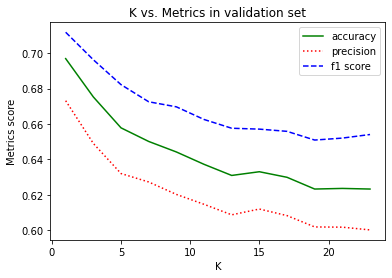

In [175]:
# Plotting K-nn metrics from validation tests

# show accuracy by k
plt.plot(knn_results.k, knn_results.accuracy, linestyle='-', c='green', label = "accuracy")
plt.plot(knn_results.k, knn_results.precision, linestyle=':', c='red', label = "precision")
plt.plot(knn_results.k, knn_results['f1_score'], linestyle='--', c='blue', label = "f1 score")
plt.legend()
plt.title('K vs. Metrics in validation set')
plt.xlabel('K')
plt.ylabel('Metrics score')

In [176]:
# Prediction using Test dataset
predictions_knn = knn.predict(testX)
probabilities_knn = knn.predict_proba(testX)[:,1]

knn_result = pd.DataFrame({'actual': testy, 
                             'probability': probabilities_knn,
                             'predicted': predictions_knn})

knn_result

,actual,probability,predicted
15247,1,0.565217,1
14974,1,0.608696,1
2200,0,0.652174,1
14434,1,0.652174,1
10707,1,0.782609,1
...,...,...,...
1023,0,0.391304,0
7506,1,0.608696,1
1415,0,0.347826,0
3362,0,0.434783,0



 Classification report for K-NN : 
               precision    recall  f1-score   support

           0       0.66      0.56      0.61       765
           1       0.64      0.73      0.69       828

    accuracy                           0.65      1593
   macro avg       0.65      0.65      0.65      1593
weighted avg       0.65      0.65      0.65      1593

Accuracy Score :  0.650345260514752
Area under curve :  0.6932106659088757 



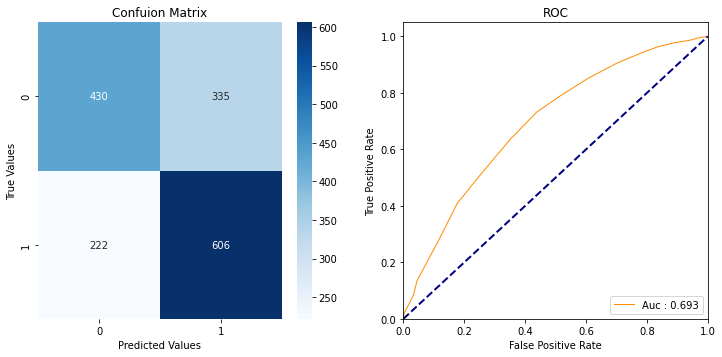

In [177]:
print ("\n Classification report for K-NN : \n",classification_report(testy,predictions_knn))
print ("Accuracy Score : ",accuracy_score(testy,predictions_knn))



#confusion matrix
conf_matrix = confusion_matrix(testy,predictions_knn)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')


#roc_auc_score
model_roc_auc = roc_auc_score(testy,probabilities_knn) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(testy,probabilities_knn)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

    
plt.show()

#### Random Forest

In [ ]:
# Train a classifier for different values of n_estimators
rf_results = []
for x in range(100, 1001, 100):
    rf = RandomForestClassifier(n_estimators = x, random_state = 1).fit(trainX, trainy)
    rf_results.append({'n_estimators': x, 'accuracy': accuracy_score(validy, rf.predict(validX)), 
                      'precision': precision_score(validy, rf.predict(validX)),
                      'f1_score': f1_score(validy, rf.predict(validX))})

    
# Convert results to a pandas data frame
rf_results = pd.DataFrame(rf_results)

In [ ]:
# show accuracy by estimators
plt.plot(rf_results['n_estimators'], rf_results.accuracy, linestyle='-', label = "accuracy")
plt.plot(rf_results['n_estimators'], rf_results.precision, linestyle=':', c='red', label = "precision")
plt.plot(rf_results['n_estimators'], rf_results['f1_score'], linestyle='--', c='blue', label = "f1 score")
plt.title('Number of estimators vs. metrics \n In validation set for Random Forest')
plt.legend()
plt.xlabel('Estimators')
plt.ylabel('Metrics score')

In [ ]:
# Prediction using Test dataset
predictions_rf = rf.predict(testX)
probabilities_rf = rf.predict_proba(testX)[:,1]

rf_result = pd.DataFrame({'actual': testy, 
                             'probability': probabilities_rf,
                             'predicted': predictions_rf})

rf_result

In [ ]:
print ("\n Classification report for Random Forest : \n",classification_report(testy,predictions_rf))
print ("Accuracy Score : ",accuracy_score(testy,predictions_rf))



#confusion matrix
conf_matrix = confusion_matrix(testy,predictions_rf)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')


#roc_auc_score
model_roc_auc = roc_auc_score(testy,probabilities_rf) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(testy,probabilities_rf)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# variable (feature) importance plot
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': trainX.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')


    
plt.show()

#### Decision Tree

In [ ]:
dt_results = []
criterion = ["gini", "entropy", "log_loss"]

for x in criterion:
    dt = DecisionTreeClassifier(criterion = x, random_state = 1).fit(trainX, trainy)
    dt_results.append({'criterion': x, 'accuracy': accuracy_score(validy, dt.predict(validX)), 
                      'precision': precision_score(validy, dt.predict(validX)),
                      'f1_score': f1_score(validy, dt.predict(validX))})
    

# Convert results to a pandas data frame
dt_results = pd.DataFrame(dt_results)

In [ ]:
dt_results.sort_values(by=["accuracy"],ascending=False)

In [ ]:
dt_results_depth = []

for x in range(2, 30, 2):
    dt = DecisionTreeClassifier(max_depth = x, criterion = "entropy", random_state = 1).fit(trainX, trainy)
    dt_results_depth.append({'max_depth': x, 'accuracy': accuracy_score(validy, dt.predict(validX)), 
                      'precision': precision_score(validy, dt.predict(validX)),
                      'f1_score': f1_score(validy, dt.predict(validX))})
dt_results_depth = pd.DataFrame(dt_results_depth)

In [ ]:
dt_results_depth

In [ ]:
# show accuracy by depth
plt.plot(dt_results_depth['max_depth'], dt_results_depth.accuracy, linestyle='-', label = "accuracy")
plt.plot(dt_results_depth['max_depth'], dt_results_depth.precision, linestyle=':', c='red', label = "precision")
plt.plot(dt_results_depth['max_depth'], dt_results_depth['f1_score'], linestyle='--', c='blue', label = "f1 score")
plt.title('Number of estimators vs. metrics \n In validation set for decision tree \n Using Entropy Loss')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Metrics score')

In [ ]:
# Prediction using Test dataset
predictions_dt = dt.predict(testX)
probabilities_dt = dt.predict_proba(testX)[:,1]

dt_result = pd.DataFrame({'actual': testy, 
                             'probability': probabilities_dt,
                             'predicted': predictions_dt})

dt_result

In [ ]:
print ("\n Classification report for Decision Tree : \n",classification_report(testy,predictions_dt))
print ("Accuracy Score : ",accuracy_score(testy,predictions_dt))



#confusion matrix
conf_matrix = confusion_matrix(testy,predictions_dt)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')


#roc_auc_score
model_roc_auc = roc_auc_score(testy,probabilities_dt) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(testy,probabilities_dt)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

    
plt.show()

#### Logistic Regression

In [ ]:
lr = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
lr.fit(trainX, trainy)

In [ ]:
print('intercept ', lr.intercept_[0])
print(pd.DataFrame({'coeff': lr.coef_[0]}, index=X.columns).transpose())

print('AIC', AIC_score(validy, lr.predict(validX), df = len(trainX.columns) + 1))

Positive correlations for factors like age, country Germany, product 2, and product 4 are linked to increased odds of a client leaving the bank. On the other hand, variables with negative coefficients are linked to staying in the bank, including having a strong credit score, a high wage, being an active member, and having a high credit score.


In [ ]:
# Prediction using Test dataset
predictions_lr = lr.predict(testX)
probabilities_lr = lr.predict_proba(testX)[:,1]

lr_result = pd.DataFrame({'actual': testy, 
                             'probability': probabilities_lr,
                             'predicted': predictions_lr})

lr_result

In [ ]:
print ("\n Classification report for Decision Tree : \n",classification_report(testy,predictions_lr))
print ("Accuracy Score : ",accuracy_score(testy,predictions_lr))



#confusion matrix
conf_matrix = confusion_matrix(testy,predictions_lr)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')


#roc_auc_score
model_roc_auc = roc_auc_score(testy,probabilities_lr) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(testy,probabilities_lr)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

    
plt.show()

#### Naive Bayes

In [ ]:
# run naive Bayes
nb = MultinomialNB(alpha=0.01)
nb.fit(trainX, trainy)

In [ ]:
# Prediction using Test dataset
predictions_nb = nb.predict(testX)
probabilities_nb = nb.predict_proba(testX)[:,1]

nb_result = pd.DataFrame({'actual': testy, 
                             'probability': probabilities_nb,
                             'predicted': predictions_nb})

nb_result

In [ ]:
print ("\n Classification report for Decision Tree : \n",classification_report(testy,predictions_nb))
print ("Accuracy Score : ",accuracy_score(testy,predictions_nb))



#confusion matrix
conf_matrix = confusion_matrix(testy,predictions_nb)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')


#roc_auc_score
model_roc_auc = roc_auc_score(testy,probabilities_nb) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(testy,probabilities_nb)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

    
plt.show()

### ROC Curve Comparision 

In [ ]:


auc_lr = roc_auc_score(testy, probabilities_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(testy, probabilities_lr)

auc_dt = roc_auc_score(testy, probabilities_dt)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(testy, probabilities_dt)

auc_knn = roc_auc_score(testy, probabilities_knn)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(testy, probabilities_knn)

auc_rf = roc_auc_score(testy, probabilities_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(testy, probabilities_rf)

auc_nb = roc_auc_score(testy, probabilities_nb)
fpr_nb, tpr_nb, thresholds_nb = roc_curve(testy, probabilities_nb)

plt.figure(figsize=(12, 7))
plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot(fpr_dt, tpr_dt, label=f'AUC (Decision Tree) = {auc_dt:.2f}')
plt.plot(fpr_knn, tpr_knn, label=f'AUC (K-NN) = {auc_knn:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'AUC (Random Forests) = {auc_rf:.2f}')
plt.plot(fpr_nb, tpr_nb, label=f'AUC (Naive Bayes) = {auc_nb:.2f}')

plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend();